# Explore Scenario Discovery

In [2]:
# !pip install altair
# !pip install ema_workbench

##  IMPORT PACKAGES
from ema_workbench.analysis import prim
from ema_workbench.util import ema_logging

import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import sys
from typing import *

# add the current directoy to the search path and load from here
dir_py = os.path.join(os.getcwd(), "python")
if dir_py not in sys.path:
    sys.path.append(dir_py)


##  Computational experiments are often used to generate large datasets, which can be condensed and used for scenario discovery
- Consider the following example data, derived from an experiment to assess the costs and benefits of decarboniation in Latin America
    - https://publications.iadb.org/en/benefits-and-costs-reaching-net-zero-emissions-latin-america-and-caribbean

- Project faced a large number of uncertainties + levers

##
## XLRM HERE

##  Read in summary dataset

- Three different experiments are summarized in this file:
    - `design_id = 0`: Emissions with No Actions taken (includes costs and benefits field, but not valid in this design)
    - `design_id = 1`: Emissions with implementation levels for groups of levers ranging from 25% to 100% (random) + uncertainties
    - `design_id = 2`: Emissions with implementation levels for groups of levers ranging from 25% to 100% (with 20% chance that a given variable will face 100% implementation or 20% that it will face 25% implementation) + uncertainties
- We will examine `design_id = 1`:
    - **Goal(s) of Experiment**: 
        - (+) Identify conditions under which the All Actions plan fails
        - (-) Identify conditions under which the All Actions plan succeeds but has low net benefits 

In [151]:
# read data
dir_ref = os.path.join(os.getcwd(), "ref")
df_exploratory_data = pd.read_csv(os.path.join(dir_ref, "pt_clean.csv"))


##  SET SOME FIELDS

field_cb = "cb_valueX"
field_emission = "emission_co2e_TOTAL_50"


##  FILTER ON DESIGN 

df_exploratory_data = (
    df_exploratory_data[
        df_exploratory_data["design_id"].isin([1])
        & (df_exploratory_data[field_cb] < np.inf)
        & (df_exploratory_data[field_cb] > -(10**14))
    ]
    .reset_index(drop = True)
)

# Let's look at some of the metrics (M) of interest
- Aggregate emissions in Latin America, MT CO2e
- Net benefits, USD

(array([  6.,  28.,  46.,  77., 145., 203., 224., 150.,  81.,  25.]),
 array([-2017.        , -1618.24690088, -1219.49380175,  -820.74070263,
         -421.98760351,   -23.23450438,   375.51859474,   774.27169386,
         1173.02479299,  1571.77789211,  1970.53099123]),
 <BarContainer object of 10 artists>)

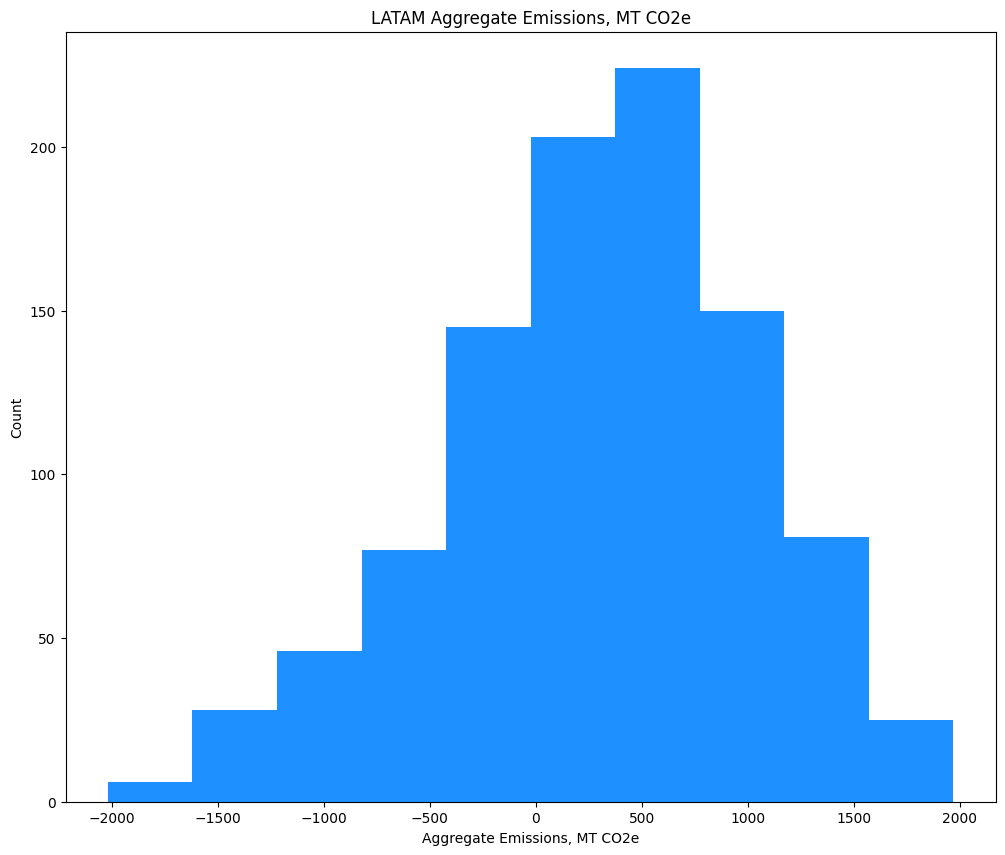

In [152]:
fig, ax = plt.subplots(figsize = (12, 10))

ax.set_title(f"LATAM Aggregate Emissions, MT CO2e")
ax.set_xlabel(f"Aggregate Emissions, MT CO2e")
ax.set_ylabel(f"Count")

ax.hist(
    df_exploratory_data[field_emission].to_numpy(),
    color = "dodgerblue" # Go Dodgers
)

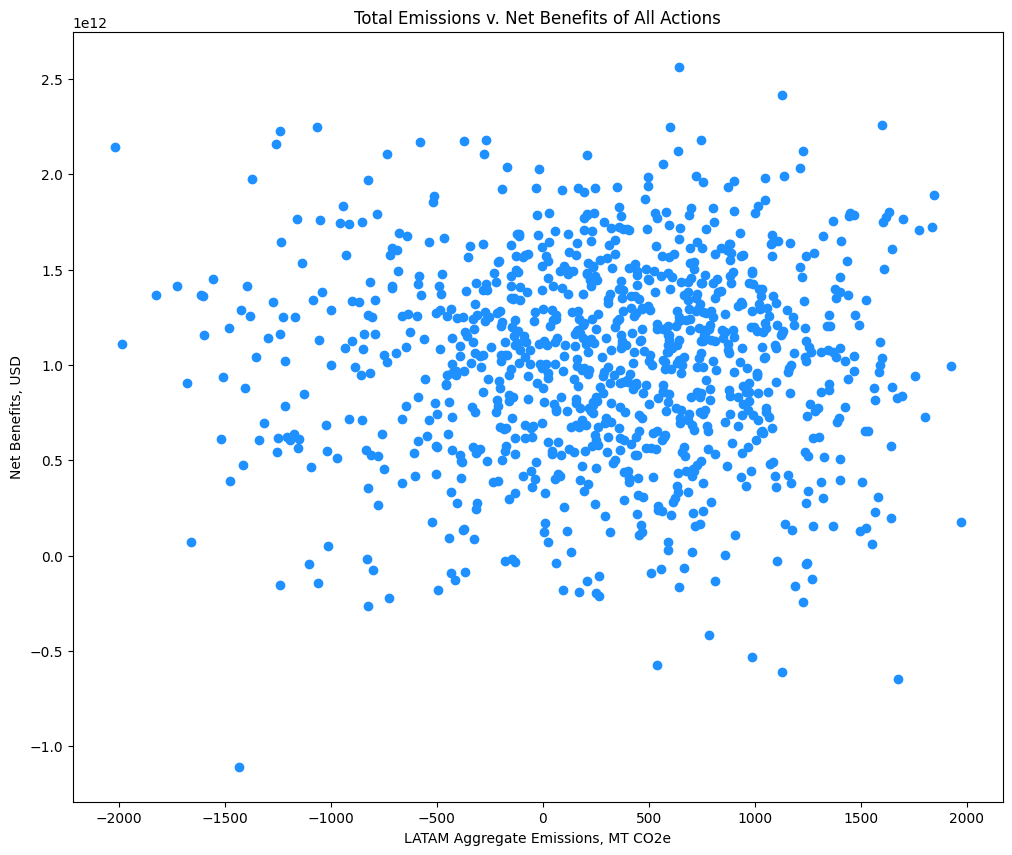

In [155]:
fig, ax = plt.subplots(figsize = (12, 10))

ax.set_title(f"Total Emissions v. Net Benefits of All Actions")
ax.set_xlabel(f"LATAM Aggregate Emissions, MT CO2e")
ax.set_ylabel(f"Net Benefits, USD")

ax.scatter(
    df_exploratory_data[field_emission].to_numpy(),
    df_exploratory_data[field_cb].to_numpy(),
    color = "dodgerblue" # Go Dodgers
)

##  Define some cases of interest

- **Cases of Interest** are those scenarios where modeling indicates that the system reaches some condition
- This is sometimes used to conduct a vulnerability assessment and understand the drivers under which a plan fails
- Let's start with one that is based exclusively on aggregate emissions and identify cases where the plan fails to meet net zero (wrt $\text{CO}_2\text{e}$ across a range of gasses and 100-year Global Warming Potential)

In [157]:
field_vuln_0 = "v0"

# let's define a vulnerability condition; an obvious one is if the actions fail to meet net zero
vec_vuln_0 = [
    int(row[field_emission] > 0) for i, row in df_exploratory_data.iterrows()
]
df_exploratory_data[field_vuln_0] = vec_vuln_0

# show the fraction of cases that are vulnerable
frac_vuln = sum(vec_vuln_0)/df_exploratory_data.shape[0]
perc_vuln = np.round(100*frac_vuln, decimals = 2)
print(f"Approximately {perc_vuln}% cases are vulnerable")

Approximately 68.43% cases are vulnerable


# Call PRIM, or **P**atient **R**ule **I**nduction **M**ethod
- PRIM is a bump-hunting algorithm that iteratively adds dimensional bounds to create boxes that best capture cases of interest
    - PRIM treats cases of interest as those where some metric is < or > a threshold
    - For our purposes, we flagged cases with a 1 (`vec_vuln_0`, above) if they were of interest and 0 otherwise
    - Cases above 0.5 meet thre threshold
- Each box represents a bound on some number of dimensions $m \leq n$ for the input space of $n$-dimensional vectors $x \in X$, $X \subset \mathbb{R}^n$ 
- The trajectory of boxes identified by PRIM create a tradeoff between **Coverage** and **Density**
    - **Coverage**: fraction of all cases of interest explained within the box, or
        
        $C(B) = \frac{|B|}{|X_1|}$,
            
        where $X_1 \subset X$ is the set of all inputs of interest ($X \subset \mathbb{R}^n$) and $B \in \mathbb{R}^m$ is an $m$-dimensional box, $m \leq n$
        
    - **Density**: fraction of all cases in the box that are of interest, or 
    
        $D(B) = \frac{|x_1 \bigcap B|}{|B|}$
            
- Other algorithms can be used to perform the same actions, such as Random Forest or CART
- To use PRIM, we must set some input variables, 

##  To use PRIM, we must set input factors or variables (X) and output variables (Y)
- For this experiment, uncertainties represented LHS trials that moved groups of uncertainties together
- Therefore, we named them simply as $X_i$ and $X^{(driver)}_i$ 
- These form the inputs to our model
    - An index, imported here as `df_index`, gives the uncertainties associated with the indices
    


In [161]:
# set some fields
fields_u = [x for x in df_exploratory_data.columns if x.startswith("u")]
fields_x = [x for x in df_exploratory_data.columns if x.startswith("X")]

# read in indexing
df_index = pd.read_csv(os.path.join(dir_ref, "variable_specification_to_sample_group.csv"))


##  For example, $x_{30}$ varies HFC and PFC emission factors uniformly to reduce the overhead of varying individual factors
- Use the `df_index` and the index to determine which variables are associated with $i$
- This is important for interpreting the output of PRIM

In [168]:
df_index[
    df_index["sample_group"].isin([30])
]

,variable_specification,sample_group
218,ef_ippu_tonne_c2f6_per_mmm_gdp_product_use_ods...,30
220,ef_ippu_tonne_c2f6_per_tonne_production_electr...,30
221,ef_ippu_tonne_c2f6_per_tonne_production_metals,30
222,ef_ippu_tonne_c2h3f3_per_mmm_gdp_product_use_o...,30
224,ef_ippu_tonne_c2hf5_per_mmm_gdp_product_use_od...,30
225,ef_ippu_tonne_c2hf5_per_mmm_gdp_product_use_od...,30
228,ef_ippu_tonne_c3f8_per_tonne_production_electr...,30
231,ef_ippu_tonne_c3h3f5_per_mmm_gdp_product_use_o...,30
232,ef_ippu_tonne_c3h3f5_per_mmm_gdp_product_use_o...,30
236,ef_ippu_tonne_c4f10_per_mmm_gdp_product_use_od...,30


##  With that in mind, let's run PRIM using EMA Workbench

In [169]:
# get input conditions to search over (x) and vector of outcomes (y)
df_x = df_exploratory_data[fields_x] # EMA prim calls a data frame as x
vec_y = df_exploratory_data[field_vuln_0].to_numpy() # numpy vector as y

prim_alg = prim.Prim(
    df_x, 
    vec_y, 
    peel_alpha = 0.1, # parameter governing # of boxes; higher number -> fewer boxes
    threshold = 0.5, # threshold 
    threshold_type = 1, # 1 -> ABOVE, 2 -> BELOW 
)
boxes = prim_alg.find_box()

##  Given the parameters we provided, PRIM identifies for a number of boxes iteratively, with dimensional restrictions increasing as it continues 
- These boxes form what is known as the *Peeling Tracjectory*, which shows the tradeoff between coverage and density
- Genereally speaking, a well-performing dataset will show a concave Pareto frontier:
    - Higher coverage is associated with a lower number of dimensional restrictions
    - Higher density is associated with a higher number of dimensional restrictions
    - Why? How do you choose a box?

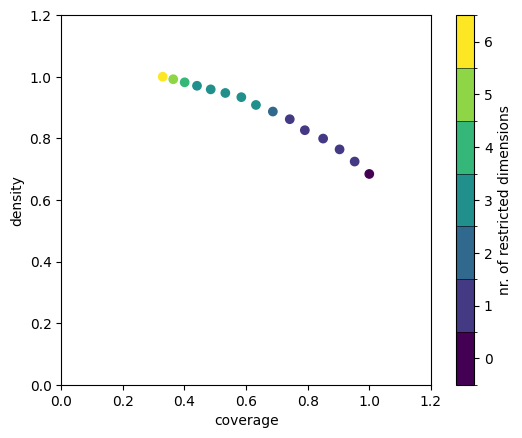

In [170]:
boxes.show_tradeoff()
plt.show()

##  EMA includes an interactive graphic
- Use `inspect_tradeoff()` method of boxes to click on each box (a dot in the peeling trajectory) and inspect the dimensional restrictions
- You can see the number of dimensions (color) and the coverage ($x$) and density ($y$)

In [149]:
boxes.inspect_tradeoff()

alt.VConcatChart(...)

##  We can look at one of the boxes in more detail using the `PrimBox.inspect()` method
- Take a look at box 6, which restricts two dimensions

In [173]:
boxes.inspect(6)

coverage      0.686944
density       0.886973
id            6.000000
k           463.000000
mass          0.529949
mean          0.886973
n           522.000000
res_dim       2.000000
Name: 6, dtype: float64

                 box 6                                 
                   min       max qp value      qp value
X277_drivers  0.000883  0.584865      NaN  3.642510e-22
X276_drivers  0.000928  0.893653      NaN  5.343146e-02



[None]

# What are the input factors, "X##"?
- Use the index to check

In [175]:
df_index[
    df_index["sample_group"].isin([276, 277])
]

,variable_specification,sample_group
216,ef_frst_sequestration_primary_kt_co2_ha,276
217,ef_frst_sequestration_secondary_kt_co2_ha,277


##  Let's get the ranges for these sequestration factors from data
- NOTE: These are illustrative, taken from Brazil, not LAC as a whole

In [195]:
rng_primary = np.array([0.648, 1.41])*0.001305406
rng_secondary = np.array([0.5, 1.5])*0.005850944

##  What do we get out of this example?
- Box 6 is defined by $0.000928 < X^{(drivers)}_{276} < 0.893653$ and $0.000883 < X^{(drivers)}_{277} < 0.584865$
- if we round the bottom end to 0 (these numbers very close to zero are likely a statistical artifact from the bottom end of LHS sampling), we find that the box is defined by sequestration factors being too low:
    - primary forest sequestration factors are below percentile 89.3653 AND
    - secondary forest sequestration factors are below percentile 58.4865

In [196]:
sf_primary_sup = rng_primary.min() + (rng_primary.max() - rng_primary.min())*0.893653
sf_secondary_sup = rng_secondary.min() + (rng_secondary.max() - rng_secondary.min())*0.584865
	
# average forest sequestration is 
sf_primary_sup, sf_secondary_sup

(0.001734837038945916, 0.00634748436256)

# If we take this in context with box 5 (and other boxes), we see that Secondary Forest emission factors are important
- If emission factors for new forests are too low, the plan is vulnerable to failure
- Why? Much of the plan relies on new forests--both through reforestation and silvopasture--to sequester carbon that continues to be emitted


In [197]:
boxes.inspect(5)

coverage      0.741840
density       0.862069
id            5.000000
k           500.000000
mass          0.588832
mean          0.862069
n           580.000000
res_dim       1.000000
Name: 5, dtype: float64

                 box 5                                 
                   min       max qp value      qp value
X277_drivers  0.000883  0.584865      NaN  3.003873e-23



[None]